# Features extractor using data augmentation
The aims of this file is to try the method of data augmentation of the previous file, combined with the "best" features extractor created in file 4.

## Librairies

In [1]:
from data_loader import load_data
import os, sys
import random
import numpy as np
import torch
from collections import OrderedDict
from extractor import Extractor
from time import time
from statistics import mean
from sklearn.metrics import accuracy_score
from keras import Model
from keras import Input
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## Pre-trained models

In [2]:
os.chdir(os.getcwd())
models_dir = 'Bacteria_TL'
sys.path.append(models_dir)

In [3]:
from training import get_predictions
from datasets import spectral_dataloader

In [4]:
models = ['pretrained_model.ckpt', 'finetuned_model.ckpt', 'clinical_pretrained_model.ckpt']

## Load data

In [5]:
X, Y, groups, _ = load_data()

## Data augmentation

### Utility functions and parameters

In [6]:
def get(patient, groups):
    l= np.where(groups == patient)
    start_idx = l[0][0]
    end_idx = l[0][len(l[0])-1]
    idx_range = list(range(start_idx, end_idx+1))
    return idx_range

In [7]:
def standard_deviation_mean(X):
    full=[]
    for i in X:
        for j in i:
            full.append(j)
    return np.std(full), mean(full)

In [8]:
stdf, meanf = standard_deviation_mean(X)

### Data augmentation functions

In [9]:
def offset_func(spectrum):
    X_offset=[]
    r=random.sample([-0.1,0.1], 1)[0]
    for i in spectrum:
        res = i+(r*stdf)
        if res > 0:
            X_offset.append(res)
        else:
            X_offset.append(0)
    return X_offset

In [10]:
def multiplication_func(spectrum):
    X_multiplication=[]
    r=random.uniform(0.9, 1.1)
    for i in spectrum:
        X_multiplication.append(i*r*stdf)
    return X_multiplication

In [11]:
def gaussian_noise_func(spectrum):
    noise = np.random.normal(meanf,stdf,len(spectrum))
    X_gaussian = []
    for i in range(len(spectrum)):
        res = spectrum[i]+noise[i]
        if res > 0:
            X_gaussian.append(res)
        else:
            X_gaussian.append(0)
    return X_gaussian

In [12]:
def data_augmentation(spectrum):
    return offset_func(spectrum), multiplication_func(spectrum), gaussian_noise_func(spectrum)

In [13]:
def augment(X_augmented, Y_augmented, groups_augmented, n, als):
    X_added=[]
    spectra_ind = get(n, groups_augmented)
    for spectrumID in spectra_ind:
        spectrum=X_augmented[spectrumID]
        offset, multiplication, gaussian_noise = data_augmentation(spectrum)
        inser = spectrumID
        X_added.append(offset)
        X_added.append(multiplication)
        X_added.append(gaussian_noise)
    last = spectra_ind[-1]+1
    for i in range(len(X_added)):
        X_augmented = np.insert(X_augmented, last+i, X_added[i], axis=0)
        Y_augmented = np.insert(Y_augmented, last+i, als)
        groups_augmented = np.insert(groups_augmented, last+i, n)
    return X_augmented, Y_augmented, groups_augmented

### Augmentation of data

In [14]:
X_augmented = X
Y_augmented = Y
groups_augmented = groups

In [15]:
for i in range(15, 20):
    X_augmented, Y_augmented, groups_augmented = augment(X_augmented, Y_augmented, groups_augmented, i, 1)

In [16]:
for i in range(20, 30):
    X_augmented, Y_augmented, groups_augmented = augment(X_augmented, Y_augmented, groups_augmented, i, 0)

## Split dataset

### Utility function

In [17]:
def createSplit(X, Y, groups, groups_selected):
    X_split = []
    Y_split = []
    for i in range(len(X)):
        if(groups[i] in groups_selected):
            X_split.append(X[i])
            Y_split.append(Y[i])
    return np.array(X_split), np.array(Y_split)

### Split
Augmented data are only use for training and validation set. Original data are keeped for test set.

In [18]:
selected_groups = random.sample(range(0, 30), 30)
train_groups = selected_groups[:18]
validation_groups = selected_groups[18:24]
test_groups = selected_groups[24:]

In [19]:
X_train, Y_train = createSplit(X_augmented, Y_augmented, groups_augmented, train_groups)
X_validation, Y_validation = createSplit(X_augmented, Y_augmented, groups_augmented, validation_groups)
X_test, Y_test = createSplit(X, Y, groups, test_groups)

## Features extractor

### Pre-trained parameters

In [20]:
base_layers = 6
hidden_size = 100
block_size = 2
input_dim = 1174
in_channels = 64
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(0)
cuda = torch.cuda.is_available()
base_to_remove = ['linear.weight', 'linear.bias']

### Utility functions

In [21]:
def removekey(d, block):
    r = dict(d)
    copy = r.copy()
    toRemove = [base_to_remove]
    if block != 0:
        toRemove.append('encoder.5')
    if block == 2:
        toRemove.append('encoder.4')
    
    for key in copy.keys():
        if (key in toRemove[0]):
            r.pop(key)
        if len(toRemove) > 1:
            if key.startswith(toRemove[1]):
                r.pop(key)
        if len(toRemove) == 3:
            if key.startswith(toRemove[2]):
                r.pop(key)
        
    return OrderedDict(r)

In [22]:
def load_model(modelToLoad, numberOfBlockToRemove):
    layers = base_layers - numberOfBlockToRemove
    hidden_sizes = [hidden_size] * layers
    num_blocks = [block_size] * layers
    model = Extractor(hidden_sizes, num_blocks)
    
    if cuda: model.cuda()
    
    checkpoint = torch.load(models_dir + '/' + modelToLoad, map_location=lambda storage, loc: storage)
    mod_weights = removekey(checkpoint, numberOfBlockToRemove)
    model.load_state_dict(mod_weights, strict=True)
    
    return model, mod_weights, checkpoint

### Extractor
The model used is the "Finetuned" one. The last block is removed.

In [23]:
extractor, _, _ = load_model(models[1], 1)

In [24]:
print(extractor)

Extractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv1d(64, 100, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=

## Features extraction

In [25]:
dl_train = spectral_dataloader(X_train, Y_train, batch_size=10, shuffle=False)
dl_validation = spectral_dataloader(X_validation, Y_validation, batch_size=10, shuffle=False)
dl_test = spectral_dataloader(X_test, Y_test, batch_size=10, shuffle=False)

### Utility function

In [26]:
def groupFeatures(X, features):
    size = len(X)
    numFeatures = len(features)
    groupSize = numFeatures//size
    X_grouped = []
    num = 1
    tmp = []
    for i in range(numFeatures):
        if num > groupSize:
            num = 1
        if num == 1:
            tmp = []
        tmp.append(features[i])
        if num == groupSize:
            X_grouped.append(tmp)
        num+=1

    return X_grouped

### Extraction

In [27]:
#Train set & finetunedNoLastBlock
t0 = time()
features_train = get_predictions(extractor, dl_train, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(features_train)//len(X_train), time()-t0))
features_train = groupFeatures(X_train, features_train)
features_train = np.array(features_train)

#Validation set & finetunedNoLastBlock
t0 = time()
features_validation = get_predictions(extractor, dl_validation, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(features_validation)//len(X_validation), time()-t0))
features_validation = groupFeatures(X_validation, features_validation)
features_validation = np.array(features_validation)

#Test set & finetunedNoLastBlock
t0 = time()
features_test = get_predictions(extractor, dl_test, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(features_test)//len(X_test), time()-t0))
features_test = groupFeatures(X_test, features_test)
features_test = np.array(features_test)

Predicted 74 features for each spectrum: 22.08s
Predicted 74 features for each spectrum: 16.95s
Predicted 74 features for each spectrum: 19.34s


## Prediction

### Utility function

In [28]:
def createModel(inputShape):
    inputs = Input(shape = inputShape)
    x = layers.Dense(128, activation = 'relu')(inputs)
    x = layers.Dense(64, activation = 'relu') (x)
    x = layers.Dense(32, activation = 'relu') (x)
    x = layers.Dense(16, activation = 'relu') (x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation = 'sigmoid') (x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-3, beta_1=0.5), metrics=["accuracy"])
    return model

In [29]:
def plotTrainResult(history, modelName):
    plt.figure(figsize=(10,7))
    plt.style.use('dark_background')
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], 'g')
    plt.plot(history.history['accuracy'], 'go')
    plt.title('Loss and accuracy obtain on the training set using ' + modelName)
    plt.ylim(0, 2)
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Accuracy'])
    plt.show()

In [30]:
def plotValResult(history, modelName):
    plt.figure(figsize=(10,7))
    plt.style.use('dark_background')
    plt.figure(figsize=(10,10))
    plt.plot(history.history['val_loss'], 'r')
    plt.plot(history.history['val_accuracy'], 'ro')
    plt.title('Loss and accuracy obtain on the validation set using ' + modelName)
    plt.ylim(0, 2)
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Accuracy'])
    plt.show()

### Creation of the model

In [31]:
model = createModel(features_train.shape[1:])

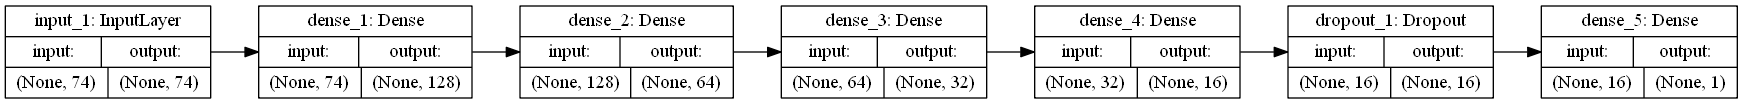

In [32]:
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='LR')

### Training

In [33]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=0)

In [34]:
batch_size=32
epochs=100

In [35]:
model_checkpoint_filepath = "checkpoints/checkpointDataAugmentation"
model_checkpoint_callback = ModelCheckpoint(filepath=model_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max',  save_best_only=True)

In [36]:
history = model.fit(features_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, model_checkpoint_callback],
          validation_data=(features_validation, Y_validation))

<Figure size 720x504 with 0 Axes>

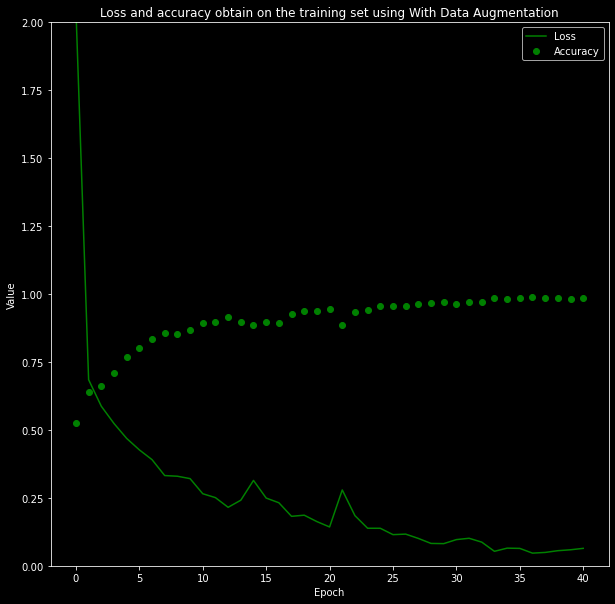

In [37]:
plotTrainResult(history, "With Data Augmentation")

<Figure size 720x504 with 0 Axes>

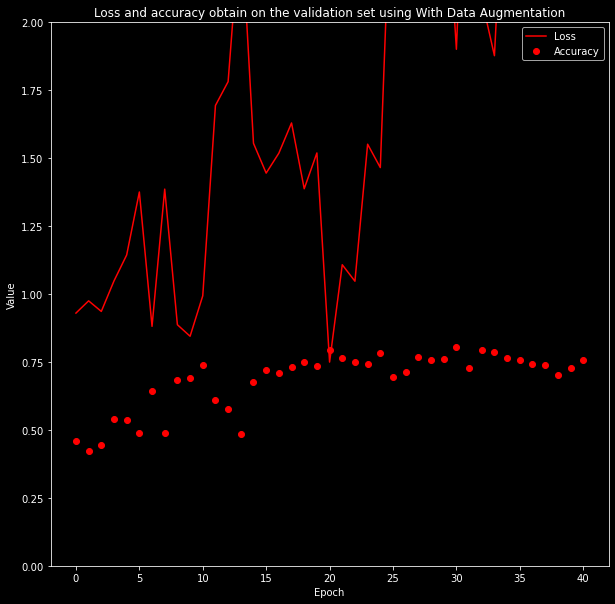

In [38]:
plotValResult(history, "With Data Augmentation")

In [39]:
model.load_weights(model_checkpoint_filepath)

### Final prediction

In [40]:
prediction = model.predict(features_test)
prediction_classes = np.where(prediction > 0.5, 1, 0)
print('Accuracy: {:0.5f}'.format(accuracy_score(Y_test, prediction_classes)))

Accuracy: 0.77041


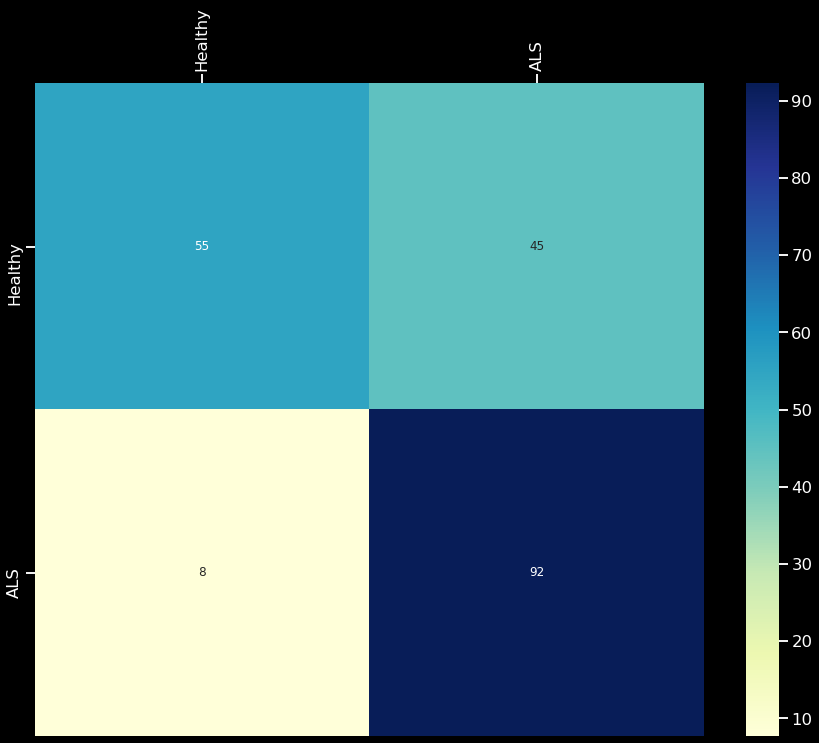

In [41]:
# Plot confusion matrix
sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = ["Healthy", "ALS"]
cm = confusion_matrix(Y_test, prediction_classes, labels=[0,1])
plt.figure(figsize=(15, 12))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()